In [9]:
import sys
!{sys.executable} -m pip install pickle5

     |████████████████████████████████| 132 kB 5.6 MB/s eta 0:00:01
  Created wheel for pickle5: filename=pickle5-0.0.11-cp38-cp38-linux_x86_64.whl size=290396 sha256=a03891e8a6902c3116868e9955a9f855955cc5fcd8788491d8e60a7e0820022a
  Stored in directory: /home/jovyan/.cache/pip/wheels/25/d4/61/dbd8edd1a0d656be7b4267c85db3b61951eb60016a0154a122
Successfully built pickle5


In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

# Clustering Optimization
* This requires the network graph generated in `001_Creating_Segment_Network_Graph`.
* Need that to get an adjacency matrix with values based on the correlation between 'nodes'. 
* In this network graph nodes are the edges and the edges are the correlations.

## No pruning of outliers (which might be a jump or 2 jumps along edges)
1. Assign correlation between nodes as edge weights
2. Find a cluster center $c_i$ randomly
3. Identify a circle with radius $r$ with center at $c_i$
4. Gather all nodes within this circle
5. Get their correlations (maybe adjacency matrix) and average them
6. Repeat with but with increasing $r \in \{r_0, r_1, \dots r_k\}$.

In [10]:
import warnings
warnings.filterwarnings('ignore')

import os
import random
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import sys
import pandas as pd
import geopandas as gpd
import numpy as np
import pickle5 as pickle
import math
import time

from tqdm.notebook import tqdm
from pprint import pprint
from copy import deepcopy
from scipy.stats.stats import pearsonr
from scipy.stats import hmean

from shapely.geometry import Point, Polygon, LineString

sys.path.append("..")
from src import network_graphing as net_graph
from src import data_processing as data_proc
from src.utils import Read_DF, Call_Back

In [11]:
# Confirm directorys are in place

if not os.path.exists(os.path.join(os.getcwd(), '../data')):
    raise OSError("Must first download data, see README.md")
data_dir = os.path.join(os.getcwd(), '../data')

if not os.path.exists(os.path.join(data_dir, 'segment_network_graphs')):
    os.mkdir(os.path.join(data_dir, 'segment_network_graphs'))
graphs_dir = os.path.join(data_dir, 'segment_network_graphs')

if not os.path.exists(os.path.join(os.getcwd(), '../img')):
    raise OSError("Must first download data, see README.md")
img_dir = os.path.join(os.getcwd(), '../img')

if not os.path.exists(os.path.join(data_dir, 'speed_data')):
    os.mkdir(os.path.join(data_dir, 'speed_data'))
speed_dir = os.path.join(data_dir, 'speed_data')

# Setting up output directories
if not os.path.exists(os.path.join(data_dir, 'generated_clusters')):
    os.mkdir(os.path.join(data_dir, 'generated_clusters'))
cluster_dir = os.path.join(data_dir, 'generated_clusters')

if not os.path.exists(os.path.join(cluster_dir, f"optimized_incident_ratios")):
    os.mkdir(os.path.join(cluster_dir, f"optimized_incident_ratios"))
incident_ratio_dir = os.path.join(cluster_dir, f"optimized_incident_ratios")

In [12]:
def list_all_segments_in_clusters(clusters):
    segments = []
    for k, v in clusters.items():
        segments = segments + v
    return segments

In [13]:
def locate_segment_cluster(segment, clusters):
    if pd.isnull(segment):
        return -1
    for i, cluster in enumerate(list(clusters)):
        if segment in clusters[cluster]:
            return cluster
    return -1

### Notes:
* Using `shapely.geometry.center_point.buffer(r)` gives a close approximation of metric distance:
    * $r = m^{-5}$, where $m$ is the desired radius away from the center_point.
    * 1000 meters = 0.01 r
* This was tested and obtained empirically on both Nashville and Metro Manila, Philippines

### Load network graph generated in `001_Creating_Segment_Network_Graph`

In [14]:
fp = os.path.join(graphs_dir, 'line_segment_graph.pkl')
G = nx.read_gpickle(fp)
print(nx.info(G))

Name: 
Type: MultiDiGraph
Number of nodes: 6906
Number of edges: 15264
Average in degree:   2.2103
Average out degree:   2.2103


### Loading speed data

In [15]:
fp = os.path.join(data_dir, 'overall_means.pkl')
df_overall_all = pd.read_pickle(fp)
active_segments = df_overall_all.droplevel([0, 1]).reset_index()['XDSegID'].unique().tolist()

In [16]:
df_overall_all.xs((0, 0, 155725149))

congestion_mean            0.087607
speed_mean                11.861111
Total_Number_Incidents     0.000000
Name: (0, 0, 155725149), dtype: float64

In [17]:
# Converting the df_overeall_all to a usable dataframe

datasets = 'congestion_mean' #congestion_mean
days_in_a_week = range(7)
week_df = []
for day in days_in_a_week:
    week_df.append(df_overall_all.xs((day))[datasets].unstack("window").T)
week_df = pd.concat(week_df, axis=0)
# starts on a monday (dayofweek=0)
_df = data_proc.convert_windows_to_dt_df(week_df, date='2019-01-07')
_df = _df[active_segments]
_df.head()

XDSegID,155725149,155730113,155742183,155751635,155783062,155791217,155792268,155795795,155796708,155802488,...,1524643235,1524643236,1524643817,1524643823,1524644550,1524644585,1524645372,1524646416,1524646417,1524646899
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-07 00:00:00,0.087607,0.0,0.008056,0.022222,0.131170,0.212972,0.096785,0.020062,0.009492,0.011838,...,0.032090,0.025346,0.097543,0.014836,0.049368,0.005659,0.023771,0.006582,0.003830,0.010686
2019-01-07 00:05:00,0.087607,0.0,0.000000,0.017296,0.137091,0.215983,0.085160,0.017485,0.009297,0.012255,...,0.021134,0.023905,0.088059,0.015903,0.054750,0.013968,0.026696,0.004487,0.006674,0.002984
2019-01-07 00:10:00,0.072222,0.0,0.000000,0.008278,0.145424,0.216760,0.082966,0.014281,0.005208,0.010772,...,0.015278,0.023905,0.088548,0.018165,0.045044,0.006725,0.034862,0.002511,0.000928,0.011048
2019-01-07 00:15:00,0.061197,0.0,0.004537,0.000000,0.101404,0.067195,0.113464,0.014090,0.004089,0.002451,...,0.010648,0.016382,0.063659,0.041118,0.063761,0.008152,0.033829,0.006595,0.005158,0.006564
2019-01-07 00:20:00,0.068376,0.0,0.009259,0.000000,0.083333,0.067249,0.112714,0.018842,0.002799,0.002451,...,0.012037,0.018118,0.065471,0.037094,0.041159,0.011034,0.029079,0.016778,0.007937,0.005961


### Selecting a random node from the map

In [18]:
# Nashville segment data (Inrix)
## Trying on nashville
fp = os.path.join(data_dir, 'inrix_grouped.pkl')
inrix_df = pd.read_pickle(fp)
inrix_df = inrix_df.set_geometry('geometry')

inrix_df.set_crs(epsg=4326, inplace=True, allow_override=True)
# inrix_df = inrix_df.to_crs('EPSG:3857')

# limit to available data sources
clusters_df = inrix_df.loc[inrix_df['XDSegID'].isin(active_segments)]

### Use 3310 CRS for measuring distances

In [19]:
original_crs = 4326
to_crs       = 3310

line_to_crs = f'line_{to_crs}'
center_to_crs = f'center_{to_crs}'

clusters_df['center'] = clusters_df['geometry'].centroid
clusters_df.set_crs(epsg=original_crs, inplace=True, allow_override=True)
clusters_df[line_to_crs] = clusters_df['geometry']
clusters_df = gpd.GeoDataFrame(clusters_df, geometry=clusters_df[line_to_crs])
clusters_df[line_to_crs] = clusters_df[line_to_crs].to_crs(epsg=to_crs)

clusters_df = clusters_df.set_geometry(line_to_crs)
clusters_df.set_crs(epsg=to_crs, inplace=True, allow_override=True)
clusters_df[center_to_crs] = clusters_df[line_to_crs].centroid.to_crs(epsg=to_crs)
# clusters_df = clusters_df[['geometry', 'XDSegID', 'line', 'center', 'center_m']]
clusters_df = clusters_df.reset_index()
clusters_df = clusters_df.drop(['index'], axis=1)
clusters_df.head()

,geometry,XDSegID,PreviousXD,NextXDSegI,FRC,County_inrix,Miles,Lanes,SlipRoad,StartLat,...,WayEndOffset_percent,iSF_length,iSF_length_min,Nearest_Weather_Station,MyGrouping_3,MyGrouping_3_id,MyGrouping_3_id_miles,center,line_3310,center_3310
0,"LINESTRING (-86.75020 36.15447, -86.75019 36.1...",155725149.0,NaN,NaN,4,davidson,0.081170,1.0,False,36.15447,...,99.994,0.999879,0.999856,723270-13897,8109145,NaN,NaN,POINT (-86.75020 36.15388),"LINESTRING (2927009.073 311631.565, 2927030.94...",POINT (2927031.956 311570.145)
1,"LINESTRING (-86.71250 36.32842, -86.71272 36.3...",155730113.0,NaN,NaN,4,davidson,0.122391,1.0,False,36.32842,...,87.591,0.999446,0.994502,723270-13897,8107390,NaN,NaN,POINT (-86.71280 36.32927),"LINESTRING (2923542.299 330946.567, 2923500.08...",POINT (2923484.547 331025.996)
2,"LINESTRING (-86.79716 36.23671, -86.79827 36.2...",155742183.0,NaN,NaN,4,davidson,0.369262,1.0,False,36.23671,...,100.000,0.962253,0.961107,723271-99999,8106100,NaN,NaN,POINT (-86.80019 36.23569),"LINESTRING (2919910.341 318766.555, 2919834.62...",POINT (2919695.747 318568.297)
3,"LINESTRING (-86.80479 36.14255, -86.80478 36.1...",155751635.0,NaN,NaN,4,davidson,0.049213,1.0,False,36.14255,...,100.000,0.999987,0.999987,723271-99999,8107412,NaN,NaN,POINT (-86.80474 36.14290),"LINESTRING (2922855.988 308703.418, 2922854.54...",POINT (2922846.919 308741.476)
4,"LINESTRING (-86.79132 36.16343, -86.79128 36.1...",155783062.0,156537635.0,449630750.0,3,davidson,0.098711,1.0,False,36.16343,...,100.000,0.991794,0.986642,723271-99999,8107410,NaN,NaN,POINT (-86.79094 36.16279),"LINESTRING (2923196.958 311297.975, 2923203.00...",POINT (2923253.709 311242.795)


# Approximation solution
* G: A network graph of the target area. Vertices $V$ are the road segments and edge weights are their correlations `TODO`
* Region: A set of road segments $v \in S$ such that they stay within the area with radius $r$ from a random vertex $u$.
* Cut: The total sum of correlations or cost of pairs where one vertex end is inside the region and the other is outside. 
* Volume: The total sum of weights of edges where both vertices are inside the region or where one vertex is outside.
### Algorithm
1. Select a random vertex
2. Set $r \to 0$
3. Stopping condition on forming regions: If cut $\leq bln(n+1) * $ volume.
4. All inside the region belong to one cluster
5. Add to array of cluster
6. Remove from overall network
7. Result is cluter array

### Values:
* n = number of segments (in this case number of vertices in G)
* b = $\frac{1}{r}$
* $p^{min}$ = minimum correlation threshold

## Updating the network graph
* Add `correlation` as weight
* Update nodes to add transformed coordinates `EPSG:3310`

### Function to get correlation between 2 segments
* Use [Pandas pearson correlation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.corr.html)

In [20]:
time_start = '06:00:00'
time_end   = '21:00:00'
data_column = 'congestion_mean'
granularity = 5
days = [0, 1, 2, 3, 4] # weekday
sub_df = _df[_df.index.dayofweek.isin(days)].between_time(time_start, time_end)

In [21]:
def get_correlation(segment_1_ID, segment_2_ID, _method='pearson'):
    segment_1_data = sub_df[segment_1_ID]
    segment_2_data = sub_df[segment_2_ID]
    return segment_1_data.corr(segment_2_data, method=_method)

### Update proper

In [22]:
# loop through edges
pbar = tqdm(total=len(G.edges))
for e in G.edges:
    xdseg_id1 = e[0]
    xdseg_id2 = e[1]
    correlation = get_correlation(xdseg_id1, xdseg_id2)
    
    centroid_m = clusters_df[clusters_df['XDSegID'] == xdseg_id1]['center_3310'].values[0]
    G.nodes[xdseg_id1]['center_m'] = (centroid_m.x, centroid_m.y)
    
    centroid_m = clusters_df[clusters_df['XDSegID'] == xdseg_id2]['center_3310'].values[0]
    G.nodes[xdseg_id2]['center_m'] = (centroid_m.x, centroid_m.y)

    G.edges[(xdseg_id1, xdseg_id2, 0)]['correlation'] = correlation
    pbar.update(1)
pbar.close()

  0%|          | 0/15264 [00:00<?, ?it/s]

In [26]:
fp = os.path.join(data_dir, 'loaded_G_correlation_weekday_6am_9pm.pkl')
nx.write_gpickle(G, fp)

In [27]:
G = nx.read_gpickle(fp)

In [28]:
print(nx.info(G))

Name: 
Type: MultiDiGraph
Number of nodes: 6906
Number of edges: 15264
Average in degree:   2.2103
Average out degree:   2.2103


### Starting the algorithm
* Defining cuts and volumes
* `correlation_threshold`: $p_{min}$

In [29]:
# Try to create a complete graph

Number of positively correlated edges: 5488


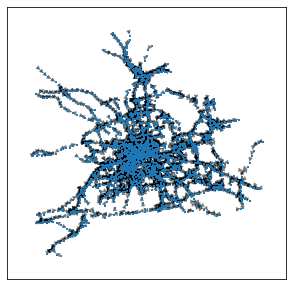

In [30]:
# Creating a sub-graph full of only edges better than the lower bound
lower_bound_correlation = 0.7
correlation_threshold = 0.85

positive_edges = [e for e in G.edges if G.get_edge_data(*e)['correlation'] >= lower_bound_correlation]
positive_nodes = list(set([n[0] for n in positive_edges] + [n[1] for n in positive_edges]))

print(f"Number of positively correlated edges: {len(positive_edges)}")
largest_wcc = positive_nodes

SG = G.__class__()
SG.add_nodes_from((n, G.nodes[n]) for n in largest_wcc)
if SG.is_multigraph():
    SG.add_edges_from((n, nbr, key, d)
        for n, nbrs in G.adj.items() if n in largest_wcc
        for nbr, keydict in nbrs.items() if nbr in largest_wcc
        for key, d in keydict.items())
else:
    SG.add_edges_from((n, nbr, d)
        for n, nbrs in G.adj.items() if n in largest_wcc
        for nbr, d in nbrs.items() if nbr in largest_wcc)
SG.graph.update(G.graph)

fig, ax = plt.subplots(figsize=(5, 5))

segs = list(SG.nodes)
geo_coords = {i: SG.nodes[i]['center_m'] for i in SG.nodes}

nx.draw_networkx_nodes(SG, pos=geo_coords, nodelist=positive_nodes, node_size=1.0, node_shape='s')
nx.draw_networkx_edges(SG, pos=geo_coords, edgelist=positive_edges, ax=ax, alpha=0.5, width=0.2, arrows=True)
plt.show()

# I could have saved time and deleted all the lower quality edges here instead
* Loop through all edges
* If correlation is lower than lower bound
    * Delete `remove_edges_from(list(tuple(node, node)))`
* Shouldn't affect anything else.

In [31]:
edges_to_remove = []
for e in SG.edges:
    corr_val = SG.get_edge_data(*e)['correlation']
    if corr_val < lower_bound_correlation:
        edges_to_remove.append(e)
print(len(edges_to_remove))
SG.remove_edges_from(edges_to_remove)

5374


In [32]:
fp = os.path.join(data_dir, f'positive_correlation_SG_{lower_bound_correlation}.pkl')
nx.write_gpickle(SG, fp)

In [33]:
SG = nx.read_gpickle(fp)

In [34]:
print(nx.info(SG))

Name: 
Type: MultiDiGraph
Number of nodes: 5553
Number of edges: 5488
Average in degree:   0.9883
Average out degree:   0.9883


# Algorithm Proper
* Check if this is correct: for both vol and cut instead of just 1 instance
                    cut_pairs.append((n_in, neighbor))
                    cut_pairs.append((neighbor, n_in))

In [35]:
# we use clusters_df since it is easier to find points
center = 'center_3310'

# Gets both positive and negative edge
def region(SG, u, r):
    if clusters_df[clusters_df['XDSegID'] == u].empty:
        return None
    
    u_pt = clusters_df[clusters_df['XDSegID'] == u][center].values[0]
    
    try:
        u_buffer = u_pt.buffer(r)
    except ValueError as e:
        print("Error:", e)
        return (None, None)
        
    # this line causes nodes not in the network graph to be used as well.
    # I should have limited this to just the nodes found in the graph, 
    # But i dont think there is any problem including them.
    # Since we only check does present in the graph for hte correlation value
    nodes_in_region = clusters_df[(clusters_df[center].within(u_buffer)) |
                                  (clusters_df[center].intersects(u_buffer))]['XDSegID'].tolist()
    node_partners_outside_region = []
    for n in nodes_in_region:
        try:
            node_partners_outside_region.extend(SG.neighbors(n))
        except Exception as e:
            pass
    node_partners_outside_region = np.setdiff1d(node_partners_outside_region, nodes_in_region) #list_2, list_1
    # yields the elements in `list_2` that are NOT in `list_1`
    
    return nodes_in_region, node_partners_outside_region

# Outside pos edge
def cut(SG, u, r, correlation_threshold):
    nodes_in_region, node_partners = region(SG, u, r)
    if not nodes_in_region:
        print("Error in cut")
        return -1
    
    cut_pairs = []
    for n_in in nodes_in_region:
        try:
            neighbors = list(SG.neighbors(n_in))
            for neighbor in neighbors:
                # I think this is safer
                if neighbor not in nodes_in_region:
                    cut_pairs.append((n_in, neighbor))
                    cut_pairs.append((neighbor, n_in))
        except Exception as e:
            pass
    
    correlations = []
    for cp in cut_pairs:
        if SG.get_edge_data(*cp, 0):
            correlation = SG.get_edge_data(*cp, 0)['correlation']
            if correlation >= correlation_threshold:
                correlations.append(correlation)
    correlations = np.asarray(correlations)
    return np.sum(correlations)

# should be inside pos edge + cut
def vol(SG, u, r, correlation_threshold):
    nodes_in_region, node_partners = region(SG, u, r)
    if not nodes_in_region:
        print("Error in Vol")
        return -1
    
    vol_pairs = []
    for n_in in nodes_in_region:
        try:
            neighbors = list(SG.neighbors(n_in))
            for neighbor in neighbors:
                if neighbor in nodes_in_region:
                    vol_pairs.append((n_in, neighbor))
                    vol_pairs.append((neighbor, n_in))
        except Exception as e:
            pass

    correlations = []
    for cp in vol_pairs:
        if SG.get_edge_data(*cp, 0):
            correlation = SG.get_edge_data(*cp, 0)['correlation']
            if correlation >= correlation_threshold:
                correlations.append(correlation)
    correlations = np.asarray(correlations)
    return np.sum(correlations) + cut(SG, u, r, correlation_threshold)

# Check all the vertices inside the region (instead of just one)
def nearest_node(SG, u, r):
    # Get all node partners that lie outside the region
    nodes_in_region, node_partners = region(SG, u, r)
    if not nodes_in_region:
        print(f"Error in nearest node {u}:{r}")
        return None, None
    
    min_distance = math.inf
    curr_partner = None
    
    for n_in in nodes_in_region:
        try:
            n_in_pt = Point(SG.nodes[n_in]['center_m'])
            neighbors = list(SG.neighbors(n_in))
            for neighbor in neighbors:
                if neighbor in nodes_in_region:
                    continue
                neighbor_pt = Point(SG.nodes[neighbor]['center_m'])
                partner_distance = n_in_pt.distance(neighbor_pt)
                if (partner_distance > r) and (partner_distance < min_distance):
                    min_distance = partner_distance
                    curr_partner = neighbor
        except Exception as e:
            pass
    return curr_partner, min_distance - r

# Algorithm

In [36]:
logging = False
random.seed(100)
clustered_nodes = []
clusters = {}
_SG = deepcopy(SG)
dead_center_nodes = []

stats_dict = {'head': [], 
              'clustered': [], 
              'remaining': [], 
              'time': [], 
              'radius': [], 
              'vol': [], 
              'cut': []}

while len(_SG.nodes) > 0:
    u = random.choice(list(_SG.nodes))
    if u in dead_center_nodes:
        continue
    i_s_time = time.time()

    # Avoid initializing a vol that is much larger than cut
    r = 1
    n = len(_SG.nodes)

    _cut = cut(_SG, u, r, correlation_threshold)
    _vol = vol(_SG, u, r, correlation_threshold)
    if logging:
        print(f"{0}:\t{r:.2f}, {_cut:.2f}, {_vol:.2f}")
        
    idx = 0
    while (_cut >= _vol) or (_cut < 0):
        _node, _dist = nearest_node(_SG, u, r)
        if not _node:
            # Dead center node
            break
        else:
            r = r + _dist + 1
            _cut = cut(_SG, u, r, correlation_threshold)
            _vol = vol(_SG, u, r, correlation_threshold)
            idx += 1
            if logging:
                print(f"{idx}:\t{r:.2f}, {_cut:.2f}, {_vol:.2f}")
            i_e_time = time.time() - i_s_time
        
    if _vol < _cut:
        # Dead center node
        dead_center_nodes.append(u)
        i_e_time = time.time() - i_s_time
        if np.isinf(_dist):
            print(f"Center: {u} cannot be clustered, reached {r:.2f} limit, {_vol:.2f}<{_cut:.2f}. Time: {i_e_time:.2f}")
        else: 
            print(f"Center: {u} cannot be clustered, vol < cut. Time: {i_e_time:.2f}")
        continue
    else:
        ck, _ = region(_SG, u, r)
        if u not in ck:
            ck.append(u)

        ck = np.setdiff1d(ck, clustered_nodes).tolist() #list_2, list_1
        clustered_nodes.extend(ck)
        _SG.remove_nodes_from(clustered_nodes)
        
        i_e_time = time.time() - i_s_time
        if len(ck) > 0:
            clusters[u] = ck
            print(f"Center: {u}, Clustered: {len(ck)}, Remaining:{len(_SG.nodes)}/{len(SG.nodes)}, radius: {r:.2f}, Time: {i_e_time:.2f}")
            stats_dict['head'].append(u)
            stats_dict['clustered'].append(len(ck))
            stats_dict['remaining'].append(len(_SG.nodes))
            stats_dict['time'].append(i_e_time)
            stats_dict['radius'].append(r)
            stats_dict['vol'].append(_vol)
            stats_dict['cut'].append(_cut)
        else:
            print(f"Center: {u} cannot be clustered, No segments inside. Time: {i_e_time:.2f}")

0:	1.00, 0.85, 0.85
1:	674.72, 4.59, 26.88
Center: 1524602415, Clustered: 33, Remaining:5522/5553, radius: 674.72, Time: 0.24
0:	1.00, 0.98, 0.98
1:	747.82, 2.79, 8.23
Center: 1524518468, Clustered: 27, Remaining:5497/5553, radius: 747.82, Time: 0.24
0:	1.00, 0.88, 4.32
Center: 1524289060, Clustered: 2, Remaining:5495/5553, radius: 1.00, Time: 0.12
0:	1.00, 0.00, 0.00
1:	167.89, 0.00, 0.86
Center: 449617512, Clustered: 4, Remaining:5491/5553, radius: 167.89, Time: 0.24
0:	1.00, 0.00, 0.00
1:	384.75, 6.58, 25.79
Center: 1524482444, Clustered: 52, Remaining:5445/5553, radius: 384.75, Time: 0.24
0:	1.00, 0.00, 0.00
Center: 449623861, Clustered: 1, Remaining:5444/5553, radius: 1.00, Time: 0.15
0:	1.00, 0.95, 0.95
1:	300.07, 0.96, 1.91
Center: 449628655, Clustered: 4, Remaining:5440/5553, radius: 300.07, Time: 0.24
0:	1.00, 1.87, 1.87
1:	105.05, 1.77, 3.76
Center: 449631116, Clustered: 4, Remaining:5436/5553, radius: 105.05, Time: 0.24
0:	1.00, 0.99, 0.99
1:	465.09, 3.93, 8.74
Center: 39610

In [37]:
# Center: 1524602415, Clustered: 33, Remaining:5522/5553, radius: 674.72, Time: 0.35

In [39]:
len(dead_center_nodes)

0

In [45]:
clustering_version = 'maxr085'

In [49]:
stats_df = pd.DataFrame(stats_dict)
fp = os.path.join(cluster_dir, f'optimized_clustering_{lower_bound_correlation}_{correlation_threshold}_{clustering_version}_stats.pkl')
stats_df.to_pickle(fp)
stats_df

,head,clustered,remaining,time,radius,vol,cut
0,1524602415,33,5522,0.237981,674.716371,26.879240,4.594022
1,1524518468,27,5497,0.239049,747.818847,8.226858,2.794388
2,1524289060,2,5495,0.118215,1.000000,4.316891,0.877551
3,449617512,4,5491,0.236911,167.887495,0.860422,0.000000
4,1524482444,52,5445,0.241627,384.748196,25.794475,6.576471
...,...,...,...,...,...,...,...
1378,156253455,2,4,0.153812,1.000000,0.000000,0.000000
1379,449622664,1,3,0.153579,1.000000,0.000000,0.000000
1380,1524314677,1,2,0.153072,1.000000,0.000000,0.000000
1381,160620191,1,1,0.152972,1.000000,0.000000,0.000000


In [50]:
stats_df[stats_df.clustered > 4]['clustered'].sum()

4479

In [51]:
fp = os.path.join(cluster_dir, f'optimized_clustering_{lower_bound_correlation}_{correlation_threshold}_{clustering_version}_stats.pkl')
stats_df = pd.read_pickle(fp)
stats_df.clustered.describe()

count    1383.000000
mean        4.782357
std         6.980824
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max        89.000000
Name: clustered, dtype: float64

In [52]:
stats_df[stats_df['clustered'] >= 4].radius.describe()

count     618.000000
mean      396.393073
std       314.002647
min         1.000000
25%       134.922284
50%       294.604121
75%       623.841063
max      1443.272039
Name: radius, dtype: float64

In [53]:
fp = os.path.join(cluster_dir, f'optimized_clustering_{lower_bound_correlation}_{correlation_threshold}_{clustering_version}_all.pkl')
with open(fp, 'wb') as handle:
    pickle.dump(clusters, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Notes:
* I could still see some negatives here and there, so i have to double check
* I will still need to clean the ratios
* add decreasing TQDM countdown
* Adjusting $b$ will control the amount of segments being clustered

# Generate the clusters with some restrictions
* For now only use clusters with 4 or more segments

In [54]:
fp = os.path.join(cluster_dir, f'optimized_clustering_{lower_bound_correlation}_{correlation_threshold}_{clustering_version}_all.pkl')
with open(fp, 'rb') as handle:
    clusters = pickle.load(handle)
    
fp = os.path.join(cluster_dir, f'optimized_clustering_{lower_bound_correlation}_{correlation_threshold}_{clustering_version}_stats.pkl')
stats_df = pd.read_pickle(fp)

restricted_heads = stats_df[stats_df.clustered >= 4]['head'].to_list()

restricted_clusters = {}
for rh in restricted_heads:
    restricted_clusters[rh] = clusters[rh]

In [55]:
print(len(restricted_clusters))
fp = os.path.join(cluster_dir, f'optimized_clustering_{lower_bound_correlation}_{correlation_threshold}_{clustering_version}_restricted.pkl')
with open(fp, 'wb') as handle:
    pickle.dump(restricted_clusters, handle, protocol=pickle.HIGHEST_PROTOCOL)

618
